In [7]:
pip install pandas seaborn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 12.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import json
import pandas as pd

# 定义根目录
root_dir = "output/xbox_infer"

# 用于存储整理后的数据
data = []



# 遍历根目录下的所有文件夹
for folder in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder)
    
    # 检查是否是文件夹
    if os.path.isdir(folder_path):
        # 定位all_metrics.jsonl文件
        metrics_file = os.path.join(folder_path, "all_metrics.jsonl")
        
        # 读取jsonl文件
        if os.path.exists(metrics_file):
            with open(metrics_file, 'r') as f:
                # 将metrics按模型和任务类型进行存储
                for line in f:
                    metric_data = json.loads(line)
                    model = folder  # 以文件夹名称作为模型名称
                    task_name = metric_data.get("task_name", "unknown_task")
                    metrics = metric_data.get("metrics", {})
                    for metric_name, metric_value in metrics.items():
                        if metric_name =="ndcg@5":
                            data.append([model, task_name, metric_name, metric_value])
                        if task_name in ["query2item", "sparse_query2item"]:
                            if metric_name =="coverage@5":
                                data.append([model, task_name, metric_name, metric_value])


# 创建DataFrame
df = pd.DataFrame(data, columns=["model", "task", "metric", "value"])

# 保存为CSV文件
output_csv_path = "output/all_models_metrics_filtered.csv"
df.to_csv(output_csv_path, index=False)

df.head()


,model,task,metric,value
0,bge-m3_v6,user2item,ndcg@5,0.103463
1,bge-m3_v6,query2item,coverage@5,0.242882
2,bge-m3_v6,sparse_query2item,coverage@5,0.411528
3,bge-m3_v6,title2item,ndcg@5,0.992249
4,bge-m3_v6,item2item,ndcg@5,0.695135


In [3]:
model_names

NameError: name 'model_names' is not defined

In [4]:
model_names

NameError: name 'model_names' is not defined

TypeError: 'Axes' object is not subscriptable

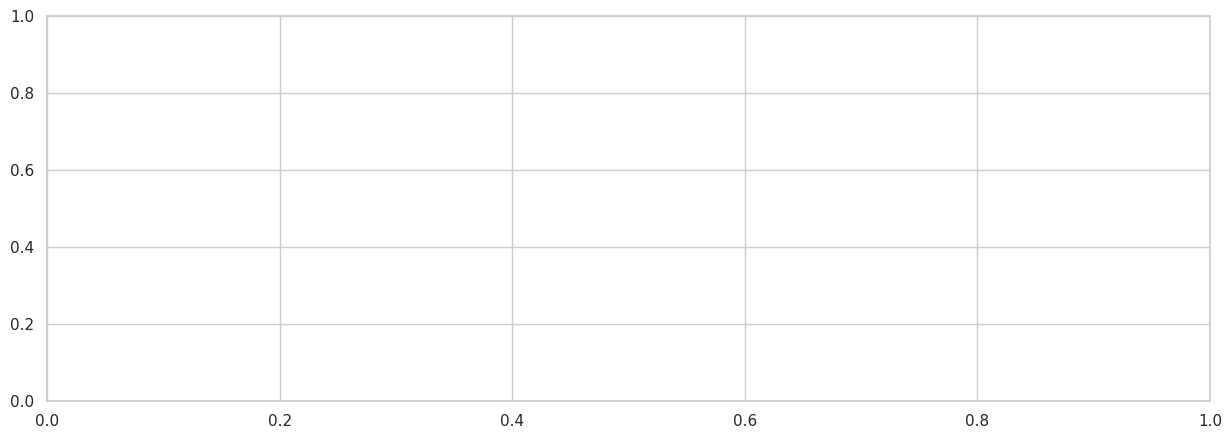

In [5]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

file_path = "./metric_images/summary.png"  # 替换为你想要保存图片的目录路径




condition_1 = df["model"].str.contains("checkpoint", na=False)
condition_2 = df["model"] == "e5-large-v2_1007"
condition_3 = df["model"] == "bge-m3-base"

# 组合条件：筛选满足任意条件的行
filtered_df = df[condition_1 | condition_2 | condition_3]

# 对 'checkpoint' 后的数字进行排序
def extract_checkpoint_number(model_name):
    if 'checkpoint' in model_name:
        return int(model_name.split('-')[-1])
    if 'bge-m3-base' == model_name:
        return int(0)
    return float('inf')  # 非 checkpoint 的模型放在最后

plot_df = filtered_df.sort_values(by="model", key=lambda x: x.map(extract_checkpoint_number))

sns.set(style="whitegrid")

# 获取所有任务的列表
tasks = plot_df["task"].unique().tolist()

# 创建一个大图用于包含所有子图
fig, axes = plt.subplots(nrows=len(tasks) + 1, ncols=1, figsize=(15, 5 * (len(tasks) + 1)))

# 遍历每个唯一的任务，绘制绝对分值的子图
for idx, task in enumerate(tasks):
    # 过滤当前任务的数据
    task_data = plot_df[plot_df["task"] == task]

    # 绘制绝对分值的折线图到子图中
    sns.lineplot(ax=axes[idx], x="model", y="value", hue="metric", data=task_data, marker='o')

    # 设置图表标题和标签
    axes[idx].set_title(f"Absolute Scores for Base and Finetuned Models on '{task}' Task")
    axes[idx].set_xlabel("Model")
    axes[idx].set_ylabel("Score")

    # 在每个点上显示具体的比例
    for line in axes[idx].lines:
        for x, y in zip(line.get_xdata(), line.get_ydata()):
            axes[idx].text(x, y, f'{y:.2%}', fontsize=9, ha='right', va='bottom')

    # 根据不同的 metric 调整刻度范围（例如覆盖范围 0 到 1，准确率等可设置在 0-1 的范围）
    axes[idx].set_ylim(0, 1)  # 默认设置在 0-1 之间

    # 调整 x 轴标签的字体大小和旋转角度
    axes[idx].tick_params(axis='x', rotation=45)

# 绘制包含所有任务的综合表现的子图
sns.lineplot(ax=axes[-1], x="model", y="value", hue="metric", data=plot_df, marker='o')
axes[-1].set_title("Absolute Scores for All Tasks")
axes[-1].set_xlabel("Model")
axes[-1].set_ylabel("Score")

# 在综合子图的每个点上显示具体的比例
for line in axes[-1].lines:
    for x, y in zip(line.get_xdata(), line.get_ydata()):
        axes[-1].text(x, y, f'{y:.2%}', fontsize=9, ha='right', va='bottom')

axes[-1].set_ylim(0, 1)
axes[-1].tick_params(axis='x', rotation=45)

# 调整子图之间的间距
plt.tight_layout()

# 保存图片到文件
plt.savefig(file_path)
plt.show()
plt.close()

In [6]:
import os
import json  
import pandas as pd

root_dir = "/home/aiscuser/RecAI/RecLM-emb/data/xbox"
tasks_count = []

# 遍历 train 和 test 目录，读取每个任务的 jsonl 文件条数
for subfolder in ["train", "test"]:
    subfolder_path = os.path.join(root_dir, subfolder)
    if os.path.isdir(subfolder_path):
        for jsonl_file in os.listdir(subfolder_path):
            if jsonl_file.endswith(".jsonl"):
                file_path = os.path.join(subfolder_path, jsonl_file)
                with open(file_path, 'r') as f:
                    line_count = sum(1 for line in f)
                tasks_count.append([subfolder, jsonl_file.replace(".jsonl", ""), line_count])

# 将任务计数数据转换为 DataFrame
tasks_df = pd.DataFrame(tasks_count, columns=["subset", "task", "line_count"])
df = pd.read_csv("/home/aiscuser/RecAI/RecLM-emb/output/all_models_metrics_filtered.csv")

merged_df = pd.merge(df, tasks_df, how="left", on="task")

# 输出到 CSV 文件
output_csv_path = "output/merged_models_metrics.csv"
merged_df.to_csv(output_csv_path, index=False)

# 展示前几行数据
merged_df.head(15)


,model,task,metric,value,subset,line_count
0,bge-m3_v6,user2item,ndcg@5,0.103463,train,55152
1,bge-m3_v6,user2item,ndcg@5,0.103463,test,50000
2,bge-m3_v6,query2item,coverage@5,0.242882,train,1152
3,bge-m3_v6,query2item,coverage@5,0.242882,test,1138
4,bge-m3_v6,sparse_query2item,coverage@5,0.411528,test,1093
5,bge-m3_v6,title2item,ndcg@5,0.992249,train,2734
6,bge-m3_v6,title2item,ndcg@5,0.992249,test,384
7,bge-m3_v6,item2item,ndcg@5,0.695135,train,863
8,bge-m3_v6,item2item,ndcg@5,0.695135,test,674
9,bge-m3_v6,queryuser2item,ndcg@5,0.830648,train,12000


In [ ]:
tasks_count

[['train', 'queryuser2item', 12000],
 ['train', 'title2item', 2685],
 ['train', 'relativequery2item', 380],
 ['train', 'negquery2item', 2127],
 ['train', 'item2item', 889],
 ['train', 'gpt_data_v2', 20741],
 ['train', 'user2item', 55343],
 ['train', 'misspell2item', 3840],
 ['train', 'query2item', 1152],
 ['train', 'gpt_data', 847],
 ['test', 'queryuser2item', 25000],
 ['test', 'title2item', 384],
 ['test', 'relativequery2item', 76],
 ['test', 'negquery2item', 4349],
 ['test', 'sparse_query2item', 1082],
 ['test', 'item2item', 665],
 ['test', 'user2item', 30000],
 ['test', 'gpt_summary_query', 454],
 ['test', 'misspell2item', 366],
 ['test', 'query2item', 1127],
 ['test', 'gpt_query', 1547],
 ['test', 'gpt_summary', 227],
 ['test', 'gpt_misspell', 137]]

In [7]:
# 使用 pivot_table 将数据转换为所需格式
pivot_df = merged_df.pivot_table(index='task', columns='subset', values='line_count', aggfunc='sum').reset_index()
pivot_df.rename(columns={'train': 'train_count', 'test': 'test_count'}, inplace=True)

# 遍历唯一的模型名称，创建每个模型的评分列
models = df['model'].unique()

# 用于存储每个模型的评分数据
model_scores_list = []

for model in models:
    model_scores = df[df['model'] == model][['task', 'metric', 'value']].drop_duplicates()

    # 保持 metric 列用于后续合并
    model_scores_pivot = model_scores.pivot_table(index=['task', 'metric'], values='value').reset_index()
    model_scores_pivot.columns = ['task', 'metric', f"{model}"]

    # 将每个模型的评分数据加入列表中
    model_scores_list.append(model_scores_pivot)

# 将所有模型的评分数据逐步合并到一个数据框中
merged_scores_df = model_scores_list[0]
for model_scores in model_scores_list[1:]:
    merged_scores_df = pd.merge(merged_scores_df, model_scores, on=['task', 'metric'], how='left')

# 将行数数据与模型评分合并
final_df = pd.merge(pivot_df, merged_scores_df, on='task', how='left')

# 保存为 CSV 文件
output_csv_path = "output/processed_metrics_summary.csv"
final_df.to_csv(output_csv_path, index=False)



In [120]:
final_df[["task","metric","bge-m3-base","bge-m3_v4"]] # ,"test_count","train_count"

,task,test_count,train_count,metric,bge-m3-base,bge-m3_v4
0,gpt_misspell,822.0,NaN,ndcg@5,0.961519,0.868957
1,gpt_query,9282.0,NaN,ndcg@5,0.237188,0.396550
2,gpt_summary,1362.0,NaN,ndcg@5,0.004076,0.109827
3,gpt_summary_query,2724.0,NaN,ndcg@5,0.050494,0.366256
4,item2item,3990.0,5334.0,ndcg@5,0.063210,0.599000
5,misspell2item,2196.0,23040.0,ndcg@5,0.820900,0.768096
6,negquery2item,26094.0,12762.0,ndcg@5,0.458925,0.987843
7,query2item,6762.0,6912.0,coverage@5,0.181399,0.252174
8,queryuser2item,150000.0,72000.0,ndcg@5,0.246815,0.853123
9,relativequery2item,456.0,2280.0,ndcg@5,0.005570,0.583532
